In [40]:
import numpy as np
import pandas as pd
import seaborn as sns

In [41]:
test = pd.read_csv('test.csv')
test.head()

,Log_Date,From,To,Sales
0,1397/01/01,3,30,NaN
1,1397/01/01,3,49,NaN
2,1397/01/01,3,66,NaN
3,1397/01/01,3,70,NaN
4,1397/01/01,4,70,NaN


In [42]:
data = pd.read_csv('data.csv')
data.FROM = data.FROM.fillna(-1).astype(int)
data.TO = data.TO.fillna(-1).astype(int)
data.head()

,Log_Time,Log_Date,AL,FROM,TO,Departure_Time,Departure_Date,Price
0,9:38:32 PM,1395/09/21,18,70,15,605.0,1395/09/22,150.2900
1,9:38:33 PM,1395/05/01,18,10,70,2250.0,1395/05/05,54.9180
2,9:38:33 PM,1396/10/08,2,3,70,2230.0,1396/10/09,72.2296
3,9:38:33 PM,1395/04/07,18,75,70,2200.0,1395/04/11,67.8452
4,9:38:33 PM,1395/04/07,18,75,70,2200.0,1395/04/11,89.4056


In [43]:
df = data.groupby(['Log_Date', 'FROM', 'TO']).size().reset_index(name='Sales')
df['Log_Year'] = df.Log_Date.str.extract('(\d+)/.*', expand=False)
df['Log_Day'] = df.Log_Date.str.extract('\d+/(.*)', expand=False)
df = pd.pivot_table(
    df,
    index=['Log_Day', 'FROM', 'TO'],
    values='Sales',
    columns='Log_Year'
)

df.fillna(0, inplace=True)

df['1397'] = test.assign(
    Log_Day=test.Log_Date.str.extract('\d+/(.*)', expand=False)
).set_index(['Log_Day', 'From', 'To'])['Sales']

df.head()

Log_Year         1395  1396  1397
Log_Day FROM TO                  
01/01   3    30   0.0   6.0   NaN
             49   0.0   5.0   NaN
             66   0.0   3.0   NaN
             70   0.0  18.0   NaN
        5    49   0.0   2.0   NaN

### Baseline #1

In [44]:
import matplotlib.pyplot as plt
from sklearn.utils import check_array
from sklearn.linear_model import LinearRegression

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = check_array(y_true)[y_true != 0]
    y_pred = check_array(y_pred)[y_true != 0]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def softplus(x): return np.log(x + 1)
def inv_softplus(x): return np.exp(x) - 1

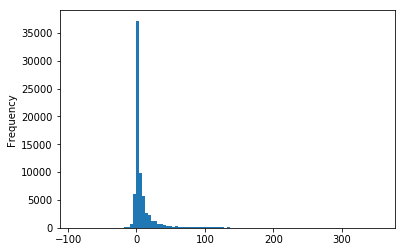

In [45]:
(df['1396'] - df['1395']).plot.hist(bins=100)

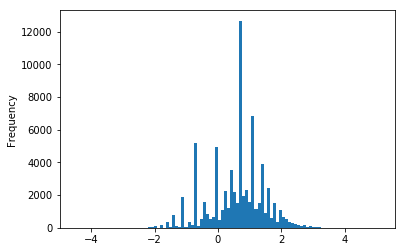

In [46]:
(softplus(df['1396']) - softplus(df['1395'])).plot.hist(bins=100)

In [56]:
X = df['1395']
Y = df['1396']

Z = df['1397']

In [57]:
train_x = df.loc[:'08/00']['1395']
val_x = df.loc['08/00':]['1395']

train_y = df.loc[:'08/00']['1396']
val_y = df.loc['08/00':]['1396']

In [58]:
lr = LinearRegression()

lr.fit(
    softplus(train_x[:, np.newaxis]),
    softplus(train_y)
)

def predict(x):
    y_ = lr.predict(softplus(x[:, np.newaxis]))
    return pd.Series(data=inv_softplus(y_), index=x.index)

df['1397'] = predict(Z).round().astype(int)

In [59]:
s = df.loc[:'09/00', '1397'].reset_index()

s['Log_Day'] = '1397/' + s.Log_Day

s.sort_values(
    ['Log_Day', 'FROM', 'TO'],
    inplace=True
)

s.rename(
    columns={
        'Log_Day': 'Log_Date',
        'FROM': 'From',
        'TO': 'To',
        '1397': 'Sales'
    },
    inplace=True
)

s.to_csv('finally.csv', index=False)

s

,Log_Date,From,To,Sales
0,1397/01/01,3,30,14
1,1397/01/01,3,49,12
2,1397/01/01,3,66,10
3,1397/01/01,3,70,28
4,1397/01/01,5,49,7
5,1397/01/01,6,70,31
6,1397/01/01,10,11,7
7,1397/01/01,10,15,6
8,1397/01/01,10,30,27
9,1397/01/01,10,42,6
